# **Project 3: Prediction the State of Charge of Batteries in Electric Vehicles**

Electric vehicles (EVs) are seen as a sustainable alternative to conventional and hybrid cars due to their zero emissions. However, one of the main challenges to their adoption is reduced driving range, particularly in cold weather. As temperatures drop, the battery’s capacity decreases, and internal resistance increases, leading to shorter driving range and longer charging times. In such conditions, accurate information about the battery's state of charge becomes crucial for optimizing energy usage and maintaining EV reliability. This project aims to predict the state of charge of batteries in electric vehicles using real measurement data, helping users plan their driving range more effectively and optimize battery usage, even in winter conditions.

# 1. Data Collection

- **Dataset Overview**:
  - Collected in southern Germany between 2019 and 2020.
  - Vehicle: 2014 BMW i3 (60 Ah).
  - Includes data from 72 trips, categorized into two groups:
    - **Warm-weather trips (Group A)**: Some measurements are missing.
    - **Cold-weather trips (Group B)**: Complete data.
     - **Source**: [Battery and Heating Data from Real Driving Cycles (IEEE DataPort)](https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles)
     .


- **Data Features**:
  - **Environmental Data**: Temperature, location, type of weather (sunny, cloudy)
  - **Vehicle Data**: Distance, duration of the trip 
  - **Battery Data**: Temperature, and State of Charge (SoC).
  - **Heating Circuit Data**: Indoor temperature

- **Purpose**:
  - Provides a rich foundation for modeling and analyzing EV performance under varying weather conditions.


The 'Overview' file, containing the aforementioned data, will be imported next.

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error


df = pd.read_excel('Overview.xlsx')

#print the column names
print (df.columns)


Index(['Trip', 'Date', 'Route/Area', 'Weather',
       'Battery Temperature (Start) [°C]', 'Battery Temperature (End)',
       'Battery State of Charge (Start)', 'Battery State of Charge (End)',
       'Unnamed: 8', 'Ambient Temperature (Start) [°C]',
       'Target Cabin Temperature', 'Distance [km]', 'Duration [min]',
       'Unnamed: 13', 'Fan', 'Note'],
      dtype='object')


I will drop some columns that are not useful for the analysis.

In [43]:
#Drop columns based on the name of the column. 'inplace' modifies df directly without needing to reassign it.
df.drop(columns=df.columns[df.columns.str.contains('Unnamed', regex=True)],inplace=True)
df.drop(columns=df.columns[df.columns.str.contains('Route/Area', regex=True)], inplace=True)
df.drop(columns=df.columns[df.columns.str.contains('Weather', regex=True)], inplace=True)
df.drop(columns=df.columns[df.columns.str.contains('Fan', regex=True)], inplace=True)
df.drop(columns=df.columns[df.columns.str.contains('Note', regex=True)], inplace=True)
df.drop(columns=df.columns[df.columns.str.contains('Target Cabin Temperature', regex=True)], inplace=True)
df.head(1)


,Trip,Date,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Ambient Temperature (Start) [°C],Distance [km],Duration [min]
0,TripA01,2019-06-25_13-21-14,21.0,22.0,0.863,0.803,25.5,7.42769,16.82


Next I want to check the format of the column Date. 

In [44]:
df['Date'] 

0     2019-06-25_13-21-14
1     2019-06-25_14-05-31
2     2019-06-28_10-02-15
3     2019-06-28_10-13-30
4     2019-06-28_10-20-26
             ...         
67    2020-01-14_12-55-08
68    2020-01-14_17-59-06
69    2020-01-15_10-43-44
70    2020-01-21_09-15-20
71    2020-02-07_09-32-02
Name: Date, Length: 72, dtype: object

I will rename the column Battery Temperature (End) and include the unit to align with the other temperature columns

In [45]:
df.rename(columns={
    'Battery Temperature (End)': 'Battery Temperature (End) [°C]'
}, inplace=True)

df.head()

,Trip,Date,Battery Temperature (Start) [°C],Battery Temperature (End) [°C],Battery State of Charge (Start),Battery State of Charge (End),Ambient Temperature (Start) [°C],Distance [km],Duration [min]
0,TripA01,2019-06-25_13-21-14,21.0,22.0,0.863,0.803,25.5,7.427690,16.820000
1,TripA02,2019-06-25_14-05-31,23.0,26.0,0.803,0.673,32.0,23.509709,23.550000
2,TripA03,2019-06-28_10-02-15,24.0,25.0,0.835,0.751,21.5,12.820846,11.180000
3,TripA04,2019-06-28_10-13-30,25.0,27.0,0.751,0.667,24.0,10.727491,6.870000
4,TripA05,2019-06-28_10-20-26,27.0,27.0,0.667,0.602,24.5,12.393223,22.776667


I believe that the date is in the format Year-Month-Day_Hour-Minute-Second. I will keep this format for now. 

# 2. Data analysis 

This section focuses on the data analysis process. The main goal is to extract insights from the dataset's features and gather relevant statistical information. Additionally, the data will be cleaned, and any outliers will be identified and removed to ensure the analysis is accurate and reliable.

# 2.1 Data Cleaning

In [46]:
def data_cleaning(df):
    # 1. Check empty rows 
    # (the readme file of the data says that there are missing rows in the group B measurements)
    count_empty_rows = df[df.isnull().all(axis=1)].shape[0]
    # Remove rows that are entirely empty (NaN values)
    df = df.dropna(how='all')

    # 2. Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    # Remove duplicate rows
    df = df.drop_duplicates()
    
    # Summary:
    print(f'\nSummary')
    print(f'Number of empty rows removed: {count_empty_rows}')
    print(f'Number of duplicates removed: {duplicate_count}')
    
    # Return the cleaned DataFrame
    return df
    
df_cleaned=data_cleaning(df)



Summary
Number of empty rows removed: 2
Number of duplicates removed: 0


The dataset has consistent measurements, only 2 rows were empty and duplicates were found. 

# 2.2 Statistical Analyses

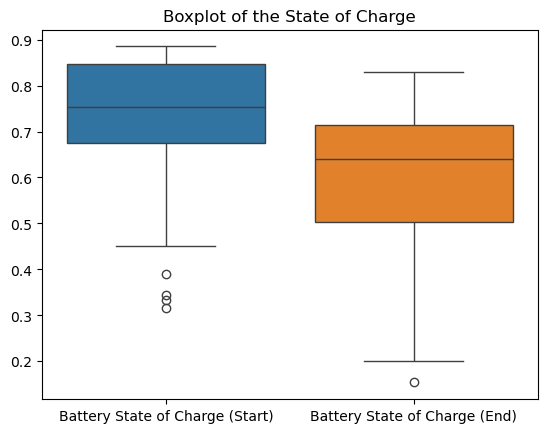

In [47]:
sns.boxplot(data=df_cleaned[['Battery State of Charge (Start)', 'Battery State of Charge (End)']])
plt.title("Boxplot of the State of Charge")  
plt.show() 


As we can see from the figure above, there are only a few outliers in the measurements of state of charge. Let's check the boxplot for the temperature measurements. 

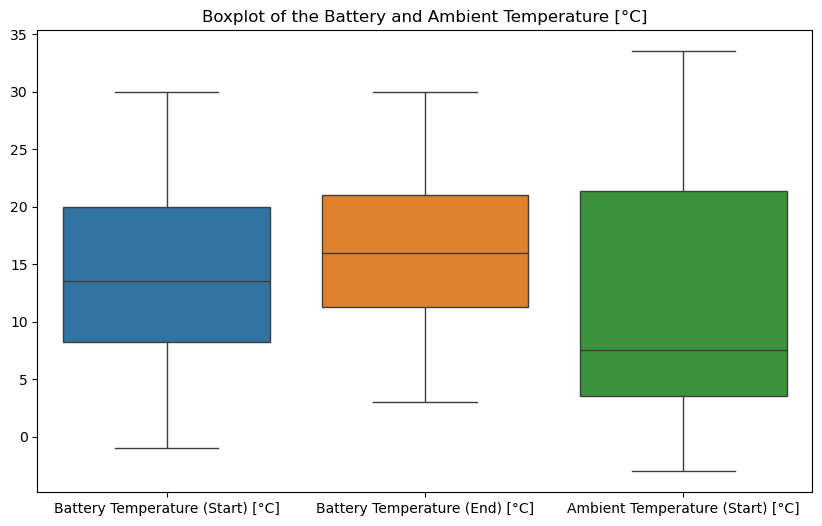

In [48]:
plt.figure(figsize=(10, 6)) # I added figsize to avoid overlap in the x-axis
sns.boxplot(data=df_cleaned[['Battery Temperature (Start) [°C]', 'Battery Temperature (End) [°C]','Ambient Temperature (Start) [°C]']])
plt.title("Boxplot of the Battery and Ambient Temperature [°C]")
plt.xticks(rotation=0, ha='center')

plt.show()


There are no significant outliers in the temperature measurements. Handling outliers can be a tricky decision, especially with small datasets. Given that there are only a few outliers in this case, I have decided to keep them for the analysis. Now, let's proceed with the statistical analysis of the measurements.

In [49]:
df_cleaned.describe()

,Battery Temperature (Start) [°C],Battery Temperature (End) [°C],Battery State of Charge (Start),Battery State of Charge (End),Ambient Temperature (Start) [°C],Distance [km],Duration [min]
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,14.257143,16.585714,0.728329,0.599014,12.364286,19.354558,26.064762
std,7.732270,6.581689,0.144845,0.164806,9.871611,11.615868,14.798017
min,-1.000000,3.000000,0.315000,0.154000,-3.000000,2.782300,5.906667
25%,8.250000,11.250000,0.674000,0.504000,3.500000,12.500129,16.862500
50%,13.500000,16.000000,0.753000,0.640000,7.500000,16.502600,23.465000
75%,20.000000,21.000000,0.847000,0.714500,21.375000,19.340116,30.521250
max,30.000000,30.000000,0.885000,0.829000,33.500000,60.974700,93.501667


The range of ambient temperature varies from -3°C to 33.5°C, while the range for the battery temperature is narrower. Additionally, the battery's state of charge remains between 0.154 and 0.829. Let's visualize the distribution of the data using histogram. 

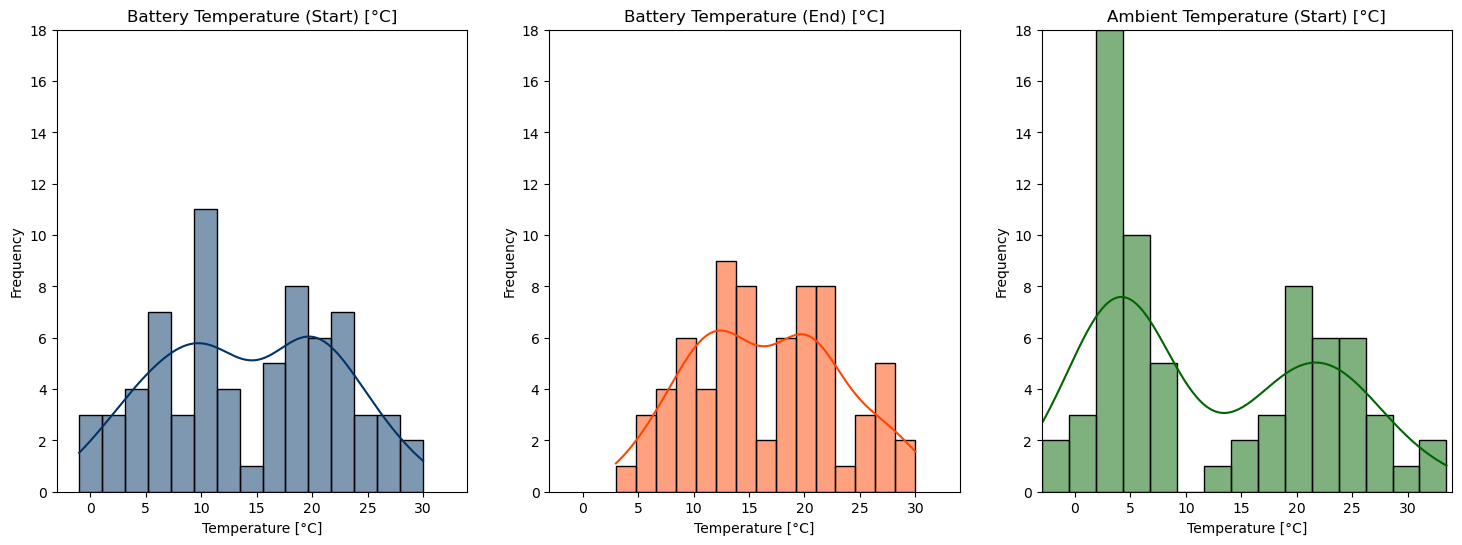

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['#003366', '#FF4500', '#006400']  # Dark blue, dark orange, dark green
x_limits=(-3,34)
y_limits=(0,18)

# Plot Battery Temperature (Start) [°C] on the first subplot
sns.histplot(data=df_cleaned['Battery Temperature (Start) [°C]'], ax=axes[0], color=colors[0],bins=15,stat='count',kde=True)
axes[0].set_title('Battery Temperature (Start) [°C]')
axes[0].set_xlabel('Temperature [°C]')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(x_limits)
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylim(y_limits)

# Plot Battery Temperature (Start) [°C] on the second subplot
sns.histplot(data=df_cleaned['Battery Temperature (End) [°C]'], ax=axes[1],color=colors[1],bins=15,stat='count',kde=True)
axes[1].set_title('Battery Temperature (End) [°C]')
axes[1].set_xlabel('Temperature [°C]')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(x_limits)
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylim(y_limits)

# Plot Ambient Temperature (Start) [°C] on the third subplot
hist_plot=sns.histplot(data=df_cleaned['Ambient Temperature (Start) [°C]'], ax=axes[2],color=colors[2],bins=15,stat='count',kde=True)
axes[2].set_title('Ambient Temperature (Start) [°C]')
axes[2].set_xlabel('Temperature [°C]')
axes[2].set_ylabel('Frequency')
axes[2].set_xlim(x_limits)
axes[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[2].set_ylim(y_limits)

plt.show()

The slight gap in the ambient temperature histogram is due to the small size of the dataset and the fact that temperatures are concentrated within specific ranges (around 5°C and around 20°C). Although this could have been omitted, I chose to display all histograms within the same temperature range, using an equal number of bins and consistent y-axis scaling (frequency), for comparison purposes. 

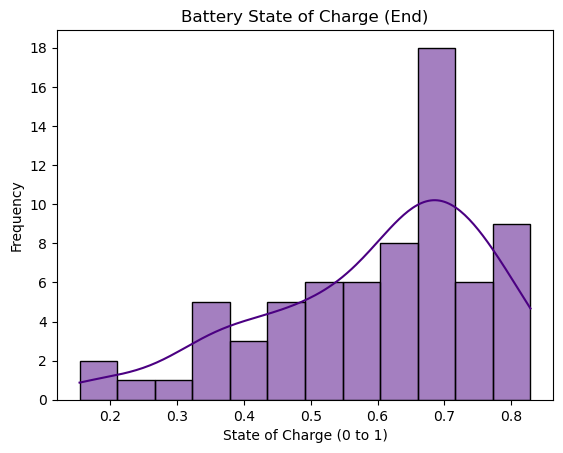

In [51]:
sns.histplot(data=df_cleaned['Battery State of Charge (End)'],color='#4B0082',bins=12,stat='count',kde=True)
plt.title('Battery State of Charge (End)')
plt.xlabel('State of Charge (0 to 1)')
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

The histogram shows that the frequency of the state of charge is higher around 0.7. We will further investigate this trend by plotting the data against the corresponding dates.

First, I will cut the time part in the 'Date' column, so that the output is Year-Month-Day. 

In [52]:
df_cleaned['Date'] = df_cleaned['Date'].astype(str)
df_cleaned['Date'] = df_cleaned['Date'].str.split('_').str[0]  

# Now convert the 'Date' column to datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce')
print(df_cleaned['Date'].head()) 

0   2019-06-25
1   2019-06-25
2   2019-06-28
3   2019-06-28
4   2019-06-28
Name: Date, dtype: datetime64[ns]


Plot the figures 

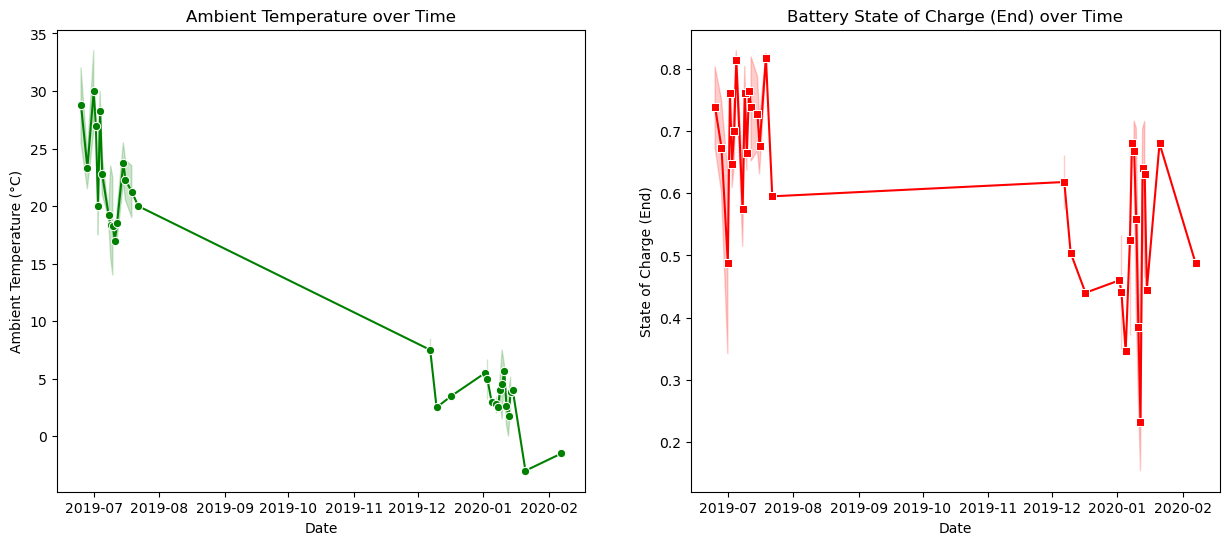

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Ambient Temperature vs Date
sns.lineplot(x='Date', y='Ambient Temperature (Start) [°C]', data=df_cleaned, ax=ax[0],color='g',marker='o')
ax[0].set_title('Ambient Temperature over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Ambient Temperature (°C)')

# Plot 2: Battery State of Charge (End) vs Date
sns.lineplot(x='Date', y='Battery State of Charge (End)', data=df_cleaned, ax=ax[1], color='r',marker='s')
ax[1].set_title('Battery State of Charge (End) over Time')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('State of Charge (End)')

plt.show()

These figures show a gap in the measurements, which can be attributed to the fact that Group A was measured during the summer, while Group B was measured in the winter. To clarify this, I will divide the analysis by group and replot the data.

In [54]:
print(df_cleaned['Trip'].unique())

['TripA01' 'TripA02' 'TripA03' 'TripA04' 'TripA05' 'TripA06' 'TripA07'
 'TripA08' 'TripA09' 'TripA10' 'TripA11' 'TripA12' 'TripA13' 'TripA14'
 'TripA15' 'TripA16' 'TripA17' 'TripA18' 'TripA19' 'TripA20' 'TripA21'
 'TripA22' 'TripA23' 'TripA24' 'TripA25' 'TripA26' 'TripA27' 'TripA28'
 'TripA29' 'TripA30' 'TripA31' 'TripA32' 'TripB01' 'TripB02' 'TripB03'
 'TripB04' 'TripB05' 'TripB06' 'TripB07' 'TripB08' 'TripB09' 'TripB10'
 'TripB11' 'TripB12' 'TripB13' 'TripB14' 'TripB15' 'TripB16' 'TripB17'
 'TripB18' 'TripB19' 'TripB20' 'TripB21' 'TripB22' 'TripB23' 'TripB24'
 'TripB25' 'TripB26' 'TripB27' 'TripB28' 'TripB29' 'TripB30' 'TripB31'
 'TripB32' 'TripB33' 'TripB34' 'TripB35' 'TripB36' 'TripB37' 'TripB38']


As we can see, the column 'Trip' has the letters A and B in the position [4]. So, I will filter the data by taking this into consideration. 

In [55]:
group_a_df = df_cleaned[df_cleaned['Trip'].str[4] == 'A']  
group_b_df = df_cleaned[df_cleaned['Trip'].str[4] == 'B'] 

# Check if there is data group A and B
print(len(group_a_df)) 
print(len(group_b_df))  

32
38


Plot the figures for group A and B 

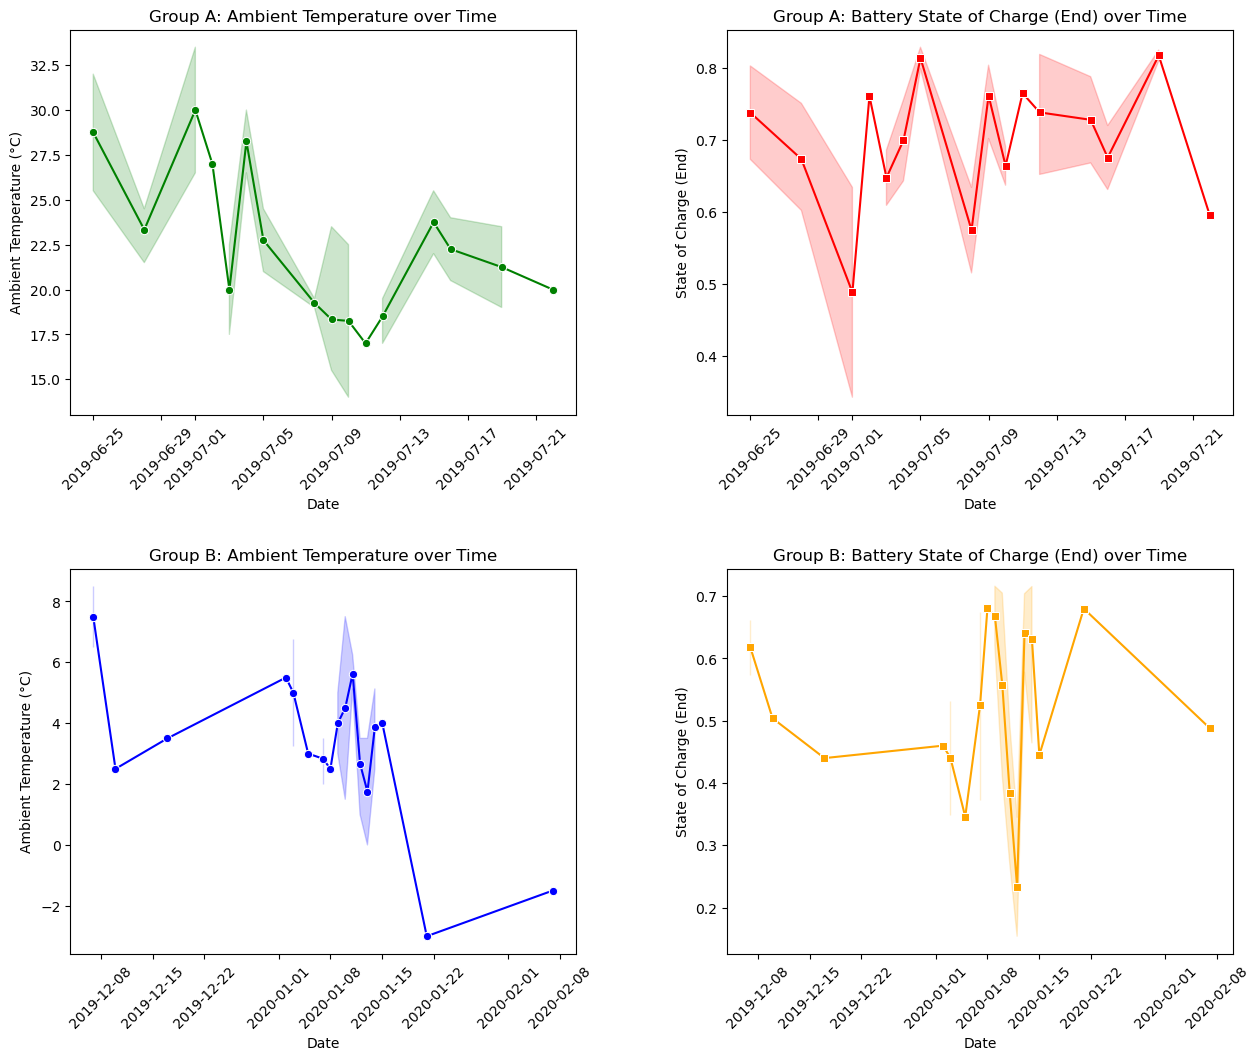

In [56]:
ig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Group A Ambient Temperature vs Date
sns.lineplot(x='Date', y='Ambient Temperature (Start) [°C]', data=group_a_df, ax=ax[0, 0], color='g', marker='o')
ax[0, 0].set_title('Group A: Ambient Temperature over Time')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Ambient Temperature (°C)')
ax[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Group A Battery State of Charge (End) vs Date
sns.lineplot(x='Date', y='Battery State of Charge (End)', data=group_a_df, ax=ax[0, 1], color='r', marker='s')
ax[0, 1].set_title('Group A: Battery State of Charge (End) over Time')
ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('State of Charge (End)')
ax[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Group B Ambient Temperature vs Date
sns.lineplot(x='Date', y='Ambient Temperature (Start) [°C]', data=group_b_df, ax=ax[1, 0], color='b', marker='o')
ax[1, 0].set_title('Group B: Ambient Temperature over Time')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Ambient Temperature (°C)')
ax[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Group B Battery State of Charge (End) vs Date
sns.lineplot(x='Date', y='Battery State of Charge (End)', data=group_b_df, ax=ax[1, 1], color='orange', marker='s')
ax[1, 1].set_title('Group B: Battery State of Charge (End) over Time')
ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('State of Charge (End)')
ax[1, 1].tick_params(axis='x', rotation=45)

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

Now, let's explore the differences between the measurements of the two groups in more detail.

In [57]:
# Calculate the average, min, and max for 'Battery State of Charge (End)' for each group
group_a_stats = group_a_df['Battery State of Charge (End)'].agg(['mean', 'min', 'max'])
group_b_stats = group_b_df['Battery State of Charge (End)'].agg(['mean', 'min', 'max'])

# Print the results
print("Group A Battery State of Charge (End) - Stats:")
print(group_a_stats)

print("\nGroup B Battery State of Charge (End) - Stats:")
print(group_b_stats)

Group A Battery State of Charge (End) - Stats:
mean    0.697937
min     0.342000
max     0.829000
Name: Battery State of Charge (End), dtype: float64

Group B Battery State of Charge (End) - Stats:
mean    0.515711
min     0.154000
max     0.716000
Name: Battery State of Charge (End), dtype: float64


### Key Insights

- **Group A (Summer)**
  - **Mean State of Charge**: ~70%, suggesting that vehicles in this group are more likely to maintain a higher charge
  - **State of Charge Range**: Between 34.2% and 82.9%
  
- **Group B (Winter)**
  - **Mean State of Charge**: ~51.6%, indicating lower average charge compared to Group A
  - **State of Charge Range**: Between 15.4% and 71.6%
  - **Variation**: The minimum state of charge (15.4%) is significantly lower than in Group A
  
- **Potential Impact of Seasonal Variation**
    - **Cold temperatures reduce battery capacity and charging efficiency**, which explains the lower state of charge in Group B compared to Group A


Now that we understand our data better, let's check the the correlation between features by creating a heatmap. 

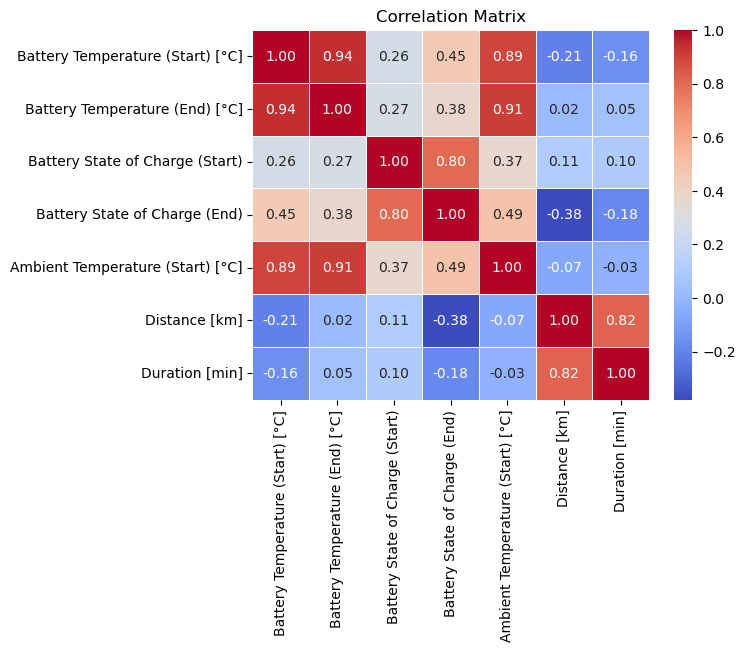

In [58]:
numeric_df = df_cleaned.select_dtypes(include=[float, int])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The heatmap above indicates a strong correlation between battery temperature, start and end times, battery state of charge at the start, and ambient temperature.

# 3. Machine Learning # 

Considering the limited size of the dataset, I will use the simplest method, i.e, linear regression. 

In [59]:
# Sorting the DataFrame by 'Date'
df_sorted = df_cleaned.sort_values(by='Date')

# Selecting features and target variable
selected_features = [
    'Battery Temperature (Start) [°C]',
    'Battery Temperature (End) [°C]',
    'Battery State of Charge (Start)',
    'Ambient Temperature (Start) [°C]',
]

X = df_sorted[selected_features]
y = df_sorted['Battery State of Charge (End)']  # Target variable


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)  # No shuffle to respect time order

# Check the sizes of the splits
print(f'Training data size: {X_train.shape[0]} samples')
print(f'Test data size: {X_test.shape[0]} samples')


Training data size: 35 samples
Test data size: 35 samples


In [60]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Linear MSE: {mse}')

Linear MSE: 0.018932660200988667


I will also compare the performance with the Lasso and Ridge regression

In [61]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

# Lasso Regression
lasso_model = Lasso(alpha=0.5) 
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

print(f"Ridge MSE: {ridge_mse}")
print(f"Lasso MSE: {lasso_mse}")

Ridge MSE: 0.034789022587915754
Lasso MSE: 0.05824418367346943


# 4. Conclusions:


The results of this project demonstrate that linear regression achieves the lowest MSE compared to the Lasso and Ridge algorithms. This can be attributed to the small size of the dataset, where simpler models such as linear regression tend to perform better. Additionally, statistical models like the Extended Kalman Filter (EKF) could potentially achieve lower MSE, which I plan to explore in future work.
